In [2]:
import torch
import pandas as pd
import numpy as np
import math

import textwrap

from typing import Optional
from diffusers import StableDiffusionPipeline
from huggingface_hub import notebook_login

import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict

notebook_login()

2025-12-14 15:49:21.004592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765727361.207217     756 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765727361.254224     756 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", # "Manojb/stable-diffusion-2-1-base" # "CompVis/stable-diffusion-v1-4",
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [5]:
def get_unet_layers(pipe, extract_resnet=False, extract_attentions=True):
    assert extract_resnet or extract_attentions
    
    nets = {}
    
    for i, block in enumerate(pipe.unet.down_blocks):
        if extract_resnet:
            for j, resnet in enumerate(block.resnets):
               nets[f"down_block_{i}_resnet_{j}"] = resnet

        if hasattr(block, "attentions") and extract_attentions:
            for j, attn in enumerate(block.attentions):
                for k, transformer in enumerate(attn.transformer_blocks):
                    name = f"down_block_{i}_attn_{j}_trans_{k}"
                    nets[name] = transformer.attn2

    if extract_resnet:
        for j, resnet in enumerate(pipe.unet.mid_block.resnets):
            nets[f"mid_block_resnet_{j}"] = resnet

    if hasattr(pipe.unet.mid_block, "attentions") and extract_attentions:
        for j, attn in enumerate(pipe.unet.mid_block.attentions):
            for k, transformer in enumerate(attn.transformer_blocks):
                name = f"mid_block_attn_{j}_trans_{k}"
                nets[name] = transformer.attn2
                
    
    for i, block in enumerate(pipe.unet.up_blocks):
        if extract_resnet:
            for j, resnet in enumerate(block.resnets):
                nets[f"up_block_{i}_resnet_{j}"] = resnet

        if hasattr(block, "attentions") and extract_attentions:
            for j, attn in enumerate(block.attentions):
                for k, transformer in enumerate(attn.transformer_blocks):
                    name = f"up_block_{i}_attn_{j}_trans_{k}"
                    nets[name] = transformer.attn2

    return nets


nets = get_unet_layers(pipe, True, True)

ALL_LAYERS = list(nets.keys())
RESNET_LAYERS = [l for l in ALL_LAYERS if 'resnet_' in l]
ATTENTION_LAYERS = [l for l in ALL_LAYERS if 'attn_' in l]

print('Resnet layers:', RESNET_LAYERS, end='\n\n')
print('Attention layers:', ATTENTION_LAYERS)

Resnet layers: ['down_block_0_resnet_0', 'down_block_0_resnet_1', 'down_block_1_resnet_0', 'down_block_1_resnet_1', 'down_block_2_resnet_0', 'down_block_2_resnet_1', 'down_block_3_resnet_0', 'down_block_3_resnet_1', 'mid_block_resnet_0', 'mid_block_resnet_1', 'up_block_0_resnet_0', 'up_block_0_resnet_1', 'up_block_0_resnet_2', 'up_block_1_resnet_0', 'up_block_1_resnet_1', 'up_block_1_resnet_2', 'up_block_2_resnet_0', 'up_block_2_resnet_1', 'up_block_2_resnet_2', 'up_block_3_resnet_0', 'up_block_3_resnet_1', 'up_block_3_resnet_2']

Attention layers: ['down_block_0_attn_0_trans_0', 'down_block_0_attn_1_trans_0', 'down_block_1_attn_0_trans_0', 'down_block_1_attn_1_trans_0', 'down_block_2_attn_0_trans_0', 'down_block_2_attn_1_trans_0', 'mid_block_attn_0_trans_0', 'up_block_1_attn_0_trans_0', 'up_block_1_attn_1_trans_0', 'up_block_1_attn_2_trans_0', 'up_block_2_attn_0_trans_0', 'up_block_2_attn_1_trans_0', 'up_block_2_attn_2_trans_0', 'up_block_3_attn_0_trans_0', 'up_block_3_attn_1_trans_0'

In [6]:
dogs_dataset = pd.read_csv('/kaggle/input/prompts-steering/dogs.csv')

dog_prompts = dogs_dataset['positive'].tolist()
non_dog_prompts = dogs_dataset['negative'].tolist()

In [17]:
def collect_average_activations(
    pipe: StableDiffusionPipeline,
    forget_set: list[str],
    retain_set: list[str],
    total_steps: int,
    guidance: float,
    nets: dict,
    layers: list[str],
    timesteps: list[int]
):
    forget_acts = []
    retain_acts = []

    for idx, (forget_prompt, retain_prompt) in enumerate(zip(forget_set, retain_set)):
        print(f'[{idx+1}] Extracting acts for forget prompt: {forget_prompt}')
        forget_act = get_average_activations(pipe, forget_prompt, total_steps, guidance, nets, layers, timesteps)

        print(f'[{idx+1}] Extracting acts for retain prompt: {retain_prompt}')
        retain_act = get_average_activations(pipe, retain_prompt, total_steps, guidance, nets, layers, timesteps)
        
        forget_acts.append(forget_act)
        retain_acts.append(retain_act)

    forget_layers = {}
    retain_layers = {}
    
    for l in layers:
        forget_layers[l] = torch.stack([f[l] for f in forget_acts], dim=0)
        retain_layers[l] = torch.stack([r[l] for r in retain_acts], dim=0)
        
    return forget_layers, retain_layers



def get_average_activations(
    pipe: StableDiffusionPipeline,
    prompt: str,
    total_steps: int,
    guidance: float,
    nets: dict,
    layers: list[str],
    timesteps: list[int]
):
    # designed to be simple, using batches would cause coherence issues when collecting acts.
    result = {}
    handles = []

    current_step = 0

    def save_act(name):
        def hook(module, input, output):           
            if current_step in timesteps:
                # UNet calculates noise prediction for both conditioned and unconditioned input, so we take the second
                residual = output[1] if isinstance(output, tuple) else output

                if residual[1].ndim == 3: # Channels x Width x Height
                    act = residual[1].mean(dim=(3, 4)).detach().cpu()
                elif residual[1].ndim == 2: # Tokens x Context 
                    act = residual[1].mean(dim=0).detach().cpu()
                else:
                    raise Exception(f'Unexpected activation shape {residual[1].shape} for {name}') 
                
                result.setdefault(name, []).append(act)
                
        return hook

    for l in layers:
        handles.append(
            nets[l].register_forward_hook(save_act(l))
        )

    def callback(pipeline, step_index, timestep, callback_kwargs):
        nonlocal current_step
        current_step = step_index

        return callback_kwargs
    
    try:
        images = pipe(
            prompt,
            num_inference_steps=total_steps,
            guidance_scale=guidance,
            callback_on_step_end=callback
        )
        
        return {
            layer: torch.stack(tensors, dim=0)
            for layer, tensors in result.items()
        } # [T, C, H, W]
    except Exception as e:
        raise e
    finally:
        for h in handles:
            h.remove()

def show_images(images: list[Image.Image], prompts: list[str], cols: int = 2, width: int = 40) -> None:
    assert len(images) == len(prompts)

    rows = math.ceil(len(images) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax in axes[len(images):]:
        ax.axis('off')

    for ax, img, prompt in zip(axes, images, prompts):
        ax.imshow(img)
        ax.axis('off')
        wrapped_prompt = "\n".join(textwrap.wrap(prompt, width=width))
        ax.text(0.5, -0.05, wrapped_prompt, fontsize=10, ha='center', va='top', transform=ax.transAxes)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)

    plt.tight_layout()
    plt.show()

In [18]:
GUIDANCE = 7.5
LAYERS = ATTENTION_LAYERS
STEPS = 30
TIMESTEPS = list(range(0, STEPS+1))

forget_acts, retain_acts = collect_average_activations(
    pipe,
    dog_prompts,
    non_dog_prompts,
    total_steps=STEPS,
    guidance=GUIDANCE,
    nets=nets,
    layers=LAYERS,
    timesteps=TIMESTEPS
)

for layer, act in forget_acts.items():
    print(f'Layer {layer}: {act.shape}')

[1] Extracting acts for forget prompt: A playful golden retriever running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[1] Extracting acts for retain prompt: A playful child running in a sunny park, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for forget prompt: A group of dogs playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[2] Extracting acts for retain prompt: A group of children playing in the snow, winter scene, cinematic lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for forget prompt: Close-up of a dog’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[3] Extracting acts for retain prompt: Close-up of a cat’s face, detailed fur and expressive eyes, portrait


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for forget prompt: A dog catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[4] Extracting acts for retain prompt: A boy catching a frisbee in mid-air, dynamic sports shot


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for forget prompt: Watercolor painting of a happy dog in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

[5] Extracting acts for retain prompt: Watercolor painting of a flower in a garden, soft pastel colors


  0%|          | 0/30 [00:00<?, ?it/s]

[6] Extracting acts for forget prompt: A dog running along the beach at sunset, golden hour lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[6] Extracting acts for retain prompt: A person jogging along the beach at sunset, golden hour lighting


  0%|          | 0/30 [00:00<?, ?it/s]

[7] Extracting acts for forget prompt: A cartoon illustration of dogs having a birthday party, colorful


  0%|          | 0/30 [00:00<?, ?it/s]

[7] Extracting acts for retain prompt: A cartoon illustration of children having a birthday party, colorful


  0%|          | 0/30 [00:00<?, ?it/s]

[8] Extracting acts for forget prompt: A dog wearing a superhero costume, funny and cute style


  0%|          | 0/30 [00:00<?, ?it/s]

[8] Extracting acts for retain prompt: A cat wearing a superhero costume, funny and cute style


  0%|          | 0/30 [00:00<?, ?it/s]

[9] Extracting acts for forget prompt: A dog swimming in a lake, splashing water, realistic style


  0%|          | 0/30 [00:00<?, ?it/s]

[9] Extracting acts for retain prompt: A duck swimming in a lake, splashing water, realistic style


  0%|          | 0/30 [00:00<?, ?it/s]

[10] Extracting acts for forget prompt: Portrait of a dog sitting on a couch, cozy indoor scene


  0%|          | 0/30 [00:00<?, ?it/s]

[10] Extracting acts for retain prompt: Portrait of a child sitting on a couch, cozy indoor scene


  0%|          | 0/30 [00:00<?, ?it/s]

[11] Extracting acts for forget prompt: A dog in a meadow chasing butterflies, cinematic composition


  0%|          | 0/30 [00:00<?, ?it/s]

[11] Extracting acts for retain prompt: A rabbit in a meadow chasing butterflies, cinematic composition


  0%|          | 0/30 [00:00<?, ?it/s]

[12] Extracting acts for forget prompt: Vintage poster of dog show competition, retro typography


  0%|          | 0/30 [00:00<?, ?it/s]

[12] Extracting acts for retain prompt: Vintage poster of cat show competition, retro typography


  0%|          | 0/30 [00:00<?, ?it/s]

[13] Extracting acts for forget prompt: A dog playing in autumn leaves, photorealistic and warm colors


  0%|          | 0/30 [00:00<?, ?it/s]

[13] Extracting acts for retain prompt: A child playing in autumn leaves, photorealistic and warm colors


  0%|          | 0/30 [00:00<?, ?it/s]

[14] Extracting acts for forget prompt: 3D render of a dog running on grass, realistic shadows


  0%|          | 0/30 [00:00<?, ?it/s]

[14] Extracting acts for retain prompt: 3D render of a horse running on grass, realistic shadows


  0%|          | 0/30 [00:00<?, ?it/s]

[15] Extracting acts for forget prompt: Dog sleeping on a cozy bed, soft morning light, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[15] Extracting acts for retain prompt: Cat sleeping on a cozy bed, soft morning light, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[16] Extracting acts for forget prompt: A dog hiking on a mountain trail, adventurous scene


  0%|          | 0/30 [00:00<?, ?it/s]

[16] Extracting acts for retain prompt: A person hiking on a mountain trail, adventurous scene


  0%|          | 0/30 [00:00<?, ?it/s]

[17] Extracting acts for forget prompt: Dogs playing tug-of-war with a rope toy, energetic scene


  0%|          | 0/30 [00:00<?, ?it/s]

[17] Extracting acts for retain prompt: Children playing tug-of-war with a rope toy, energetic scene


  0%|          | 0/30 [00:00<?, ?it/s]

[18] Extracting acts for forget prompt: A dog in a superhero comic scene, dynamic action pose


  0%|          | 0/30 [00:00<?, ?it/s]

[18] Extracting acts for retain prompt: A cat in a superhero comic scene, dynamic action pose


  0%|          | 0/30 [00:00<?, ?it/s]

[19] Extracting acts for forget prompt: A puppy exploring a garden, curiosity and wonder, detailed


  0%|          | 0/30 [00:00<?, ?it/s]

[19] Extracting acts for retain prompt: A rabbit exploring a garden, curiosity and wonder, detailed


  0%|          | 0/30 [00:00<?, ?it/s]

[20] Extracting acts for forget prompt: Dogs at a beach party, umbrellas and toys, vibrant colors


  0%|          | 0/30 [00:00<?, ?it/s]

[20] Extracting acts for retain prompt: Children at a beach party, umbrellas and toys, vibrant colors


  0%|          | 0/30 [00:00<?, ?it/s]

[21] Extracting acts for forget prompt: A dog enjoying a car ride, head out the window, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[21] Extracting acts for retain prompt: A cat enjoying a car ride, head out the window, photorealistic


  0%|          | 0/30 [00:00<?, ?it/s]

[22] Extracting acts for forget prompt: A dog sitting by a fireplace on a cozy winter evening


  0%|          | 0/30 [00:00<?, ?it/s]

[22] Extracting acts for retain prompt: A child sitting by a fireplace on a cozy winter evening


  0%|          | 0/30 [00:00<?, ?it/s]

[23] Extracting acts for forget prompt: A dog puppy playing with a colorful ball, close-up


  0%|          | 0/30 [00:00<?, ?it/s]

[23] Extracting acts for retain prompt: A kitten playing with a colorful ball, close-up


  0%|          | 0/30 [00:00<?, ?it/s]

[24] Extracting acts for forget prompt: Dogs running through a field of flowers, bright and vivid


  0%|          | 0/30 [00:00<?, ?it/s]

[24] Extracting acts for retain prompt: Horses running through a field of flowers, bright and vivid


  0%|          | 0/30 [00:00<?, ?it/s]

[25] Extracting acts for forget prompt: A dog jumping over an obstacle in an agility competition


  0%|          | 0/30 [00:00<?, ?it/s]

[25] Extracting acts for retain prompt: A horse jumping over an obstacle in an equestrian competition


  0%|          | 0/30 [00:00<?, ?it/s]

[26] Extracting acts for forget prompt: A dog playing in a puddle after rain, splashing water


  0%|          | 0/30 [00:00<?, ?it/s]

[26] Extracting acts for retain prompt: A child playing in a puddle after rain, splashing water


  0%|          | 0/30 [00:00<?, ?it/s]

[27] Extracting acts for forget prompt: A dog dressed in a festive Halloween costume, funny


  0%|          | 0/30 [00:00<?, ?it/s]

[27] Extracting acts for retain prompt: A cat dressed in a festive Halloween costume, funny


  0%|          | 0/30 [00:00<?, ?it/s]

[28] Extracting acts for forget prompt: A dog resting in a hammock on a tropical beach, relaxing


  0%|          | 0/30 [00:00<?, ?it/s]

[28] Extracting acts for retain prompt: A person resting in a hammock on a tropical beach, relaxing


  0%|          | 0/30 [00:00<?, ?it/s]

[29] Extracting acts for forget prompt: A dog performing tricks in a circus, colorful scene


  0%|          | 0/30 [00:00<?, ?it/s]

[29] Extracting acts for retain prompt: A clown performing tricks in a circus, colorful scene


  0%|          | 0/30 [00:00<?, ?it/s]

[30] Extracting acts for forget prompt: A dog running alongside a bicycle on a sunny day, action shot


  0%|          | 0/30 [00:00<?, ?it/s]

[30] Extracting acts for retain prompt: A child running alongside a bicycle on a sunny day, action shot


  0%|          | 0/30 [00:00<?, ?it/s]

Layer down_block_0_attn_0_trans_0: torch.Size([30, 31, 320])
Layer down_block_0_attn_1_trans_0: torch.Size([30, 31, 320])
Layer down_block_1_attn_0_trans_0: torch.Size([30, 31, 640])
Layer down_block_1_attn_1_trans_0: torch.Size([30, 31, 640])
Layer down_block_2_attn_0_trans_0: torch.Size([30, 31, 1280])
Layer down_block_2_attn_1_trans_0: torch.Size([30, 31, 1280])
Layer mid_block_attn_0_trans_0: torch.Size([30, 31, 1280])
Layer up_block_1_attn_0_trans_0: torch.Size([30, 31, 1280])
Layer up_block_1_attn_1_trans_0: torch.Size([30, 31, 1280])
Layer up_block_1_attn_2_trans_0: torch.Size([30, 31, 1280])
Layer up_block_2_attn_0_trans_0: torch.Size([30, 31, 640])
Layer up_block_2_attn_1_trans_0: torch.Size([30, 31, 640])
Layer up_block_2_attn_2_trans_0: torch.Size([30, 31, 640])
Layer up_block_3_attn_0_trans_0: torch.Size([30, 31, 320])
Layer up_block_3_attn_1_trans_0: torch.Size([30, 31, 320])
Layer up_block_3_attn_2_trans_0: torch.Size([30, 31, 320])


In [95]:
def compute_scores(retain_acts, forget_acts, timesteps, top_k):
    results = {}

    for timestep in timesteps :
        timestep_dict = {}
        for layer in retain_acts:
            P = retain_acts[layer][:, timestep-timesteps[0], :].float()  # Positive (N, D)
            N = forget_acts[layer][:, timestep-timesteps[0], :].float()  # Negative (N, D)
    
            if P.shape != N.shape:
                print(f'P shape and N shape differs in {layer}')
    
            n_samples = P.shape[0]
    
            all_acts = torch.cat([P, N], dim=0) # (2N, D)
            mu_l = all_acts.mean(dim=0, keepdim=True)  # (1, D)
            sigma_l = all_acts.std(dim=0, keepdim=True) + 1e-8 # (1, D)
    
            P_tilde = (P - mu_l) / sigma_l
            N_tilde = (N - mu_l) / sigma_l

            v_l = (N - P).mean(dim=0)
    
            
            # Calculate means of normalized data
            mu_pos = P_tilde.mean(dim=0) # (D)
            mu_neg = N_tilde.mean(dim=0) # (D)
    
            # Instead of creating (D, D) matrix, project means onto v_l
            proj_pos = torch.dot(mu_pos, v_l)
            proj_neg = torch.dot(mu_neg, v_l)
            
            # v^T Sb v = N * (proj_pos^2 + proj_neg^2)
            sb_val = n_samples * (proj_pos**2 + proj_neg**2)
    
            # Center the data class-wise
            P_centered = P_tilde - mu_pos.unsqueeze(0) # (N, D)
            N_centered = N_tilde - mu_neg.unsqueeze(0) # (N, D)
    
            # Instead of creating (D, D) covariance, project data onto v_l
            # This calculates the variance of the data along the direction of v_l
            p_proj = torch.mv(P_centered, v_l) # (N)
            n_proj = torch.mv(N_centered, v_l) # (N)
    
            sw_pos_val = torch.sum(p_proj**2)
            sw_neg_val = torch.sum(n_proj**2)
            sw_val = sw_pos_val + sw_neg_val
    
            
            D_l = (sb_val / (sb_val + sw_val + 1e-8)).item()
    
            pair_diffs = N_tilde - P_tilde # (N, D)
            dot_products = torch.mv(pair_diffs, v_l) # (N)
            pair_norms = torch.norm(pair_diffs, dim=1) # (N,)
            v_norm = torch.norm(v_l)
            
            cosine_sims = dot_products / (pair_norms * v_norm + 1e-8)
            C_l = cosine_sims.mean().item()
    
            S_l = D_l + C_l
    
            timestep_dict[layer] = {
                "score": S_l,
                "discriminability": D_l,
                "consistency": C_l
            }
            
            del P_tilde, N_tilde, all_acts, P_centered, N_centered
            torch.cuda.empty_cache()
            
        sorted_layers = sorted(timestep_dict.items(), key=lambda x: x[1]['score'], reverse=True)
        results[timestep] = [x for x in sorted_layers[:top_k]]
        
    return results

def get_top_k_layers(results):
    res = {}
    for timestep, top in results.items():
        res[timestep] = [x[0] for x in top]
    return res

def print_report(results):
    for timestep, top in results.items():
        print(f"Timestep: {timestep}")
        for layer, score_dict in top:
            score, disc, cons = score_dict['score'], score_dict['discriminability'], score_dict['consistency']
            print(f'\tLayer: {layer} | Score: {score} | Disc: {disc} | Cons: {cons}')

def mask_vectors_by_top_k(steering_vectors, timesteps, top_k_per_timestep):
    masked_vectors = {l: v.clone() for l, v in steering_vectors.items()}
    
    for ts_index, step in enumerate(timesteps):
        active_layers = top_k_per_timestep.get(step, [])
        
        for layer_name, vector_tensor in masked_vectors.items():
            # If this layer is NOT in the active list for this step, zero it out
            if layer_name not in active_layers:
                vector_tensor[ts_index] = 0.0

    return masked_vectors

In [102]:
results = compute_scores(retain_acts, forget_acts, timesteps=TIMESTEPS, top_k=5)

top_k_per_timestep = get_top_k_layers(results)
print_report(results)

Timestep: 0
	Layer: mid_block_attn_0_trans_0 | Score: 1.5201204419136047 | Disc: 0.8749938607215881 | Cons: 0.6451265811920166
	Layer: down_block_2_attn_1_trans_0 | Score: 1.4516133666038513 | Disc: 0.8298435807228088 | Cons: 0.6217697858810425
	Layer: down_block_2_attn_0_trans_0 | Score: 1.4140915870666504 | Disc: 0.7937405109405518 | Cons: 0.6203510761260986
	Layer: up_block_1_attn_2_trans_0 | Score: 1.3619330525398254 | Disc: 0.8154619932174683 | Cons: 0.5464710593223572
	Layer: up_block_1_attn_0_trans_0 | Score: 1.3571938872337341 | Disc: 0.8102625608444214 | Cons: 0.5469313263893127
Timestep: 1
	Layer: mid_block_attn_0_trans_0 | Score: 1.5017524361610413 | Disc: 0.8678128719329834 | Cons: 0.6339395642280579
	Layer: down_block_2_attn_1_trans_0 | Score: 1.436993956565857 | Disc: 0.8240877985954285 | Cons: 0.6129061579704285
	Layer: down_block_2_attn_0_trans_0 | Score: 1.402734398841858 | Disc: 0.7962172627449036 | Cons: 0.6065171360969543
	Layer: up_block_2_attn_2_trans_0 | Score: 1

In [97]:
BEST_LAYERS = list(set([l[0] for value in results.values() for l in value]))

BEST_LAYERS

['up_block_1_attn_2_trans_0',
 'up_block_2_attn_0_trans_0',
 'down_block_2_attn_1_trans_0',
 'up_block_2_attn_1_trans_0',
 'up_block_1_attn_0_trans_0',
 'up_block_2_attn_2_trans_0',
 'mid_block_attn_0_trans_0',
 'down_block_2_attn_0_trans_0',
 'up_block_1_attn_1_trans_0']

In [138]:
def contrastive_pca(X, Y, alpha: float = 1.0, threshold: float = 0.95, min_eigen: float = 0.5):
    X = X.float()
    Y = Y.float()

    X_center = X.mean(dim=0, keepdim=True)
    Xc = X - X_center
    Yc = Y - Y.mean(dim=0, keepdim=True)
    
    N, D = Xc.shape
    M, _ = Yc.shape

    S_X = (Xc.T @ Xc) / (N - 1)
    S_Y = (Yc.T @ Yc) / (M - 1)

    S_c = S_X - alpha * S_Y

    eigvals, eigvecs = torch.linalg.eigh(S_c)

    eigvals, idx = torch.sort(eigvals, descending=True)
    eigvecs = eigvecs[:, idx]

    mask = eigvals > min_eigen
    eigvals_pos = eigvals[mask]
    eigvecs_pos = eigvecs[:, mask]

    cum_var = torch.cumsum(eigvals_pos, dim=0) / eigvals_pos.sum()
    num_components = (cum_var < threshold).sum() + 1

    eigvals_selected = eigvals_pos[:num_components]
    eigvecs_selected = eigvecs_pos[:, :num_components]

    return eigvecs_selected.cpu(), eigvals_selected.cpu(), X_center.cpu()


def compute_principal_components(forget_acts, retain_acts, layers: list[str], min_subspace_dim: int = 5, alpha: float = 1.0, threshold: float = 0.95, min_eigen: float = 0.5):
    result = defaultdict(lambda: defaultdict(int))
    for (layer, X), (_, Y) in zip(forget_acts.items(), retain_acts.items()): 
        X = forget_acts[layer]
        Y = retain_acts[layer]

        assert X.shape == Y.shape

        for ts in range(X.size(1)):
            eigvecs, eigvals, mean = contrastive_pca(X[:, ts, :], Y[:, ts, :], alpha, threshold, min_eigen)

            if len(eigvals) >= min_subspace_dim: # we require at least 5 PC  
                print(f'Layer {layer}: shape: {X.shape} ts: {ts}, eigvecs: {eigvecs.shape}, eigvals: {eigvals.tolist()}')
                result[layer][ts] = (eigvecs, mean)

    return result

layer_principal_components = compute_principal_components(
    forget_acts,
    retain_acts,
    layers=BEST_LAYERS,
    min_subspace_dim=5,
    alpha=10,
    threshold=0.90,
    min_eigen=0.01
)

Layer down_block_1_attn_0_trans_0: shape: torch.Size([30, 31, 640]) ts: 0, eigvecs: torch.Size([640, 5]), eigvals: [0.02805316261947155, 0.025127511471509933, 0.01946977525949478, 0.016177188605070114, 0.011938954703509808]
Layer down_block_1_attn_0_trans_0: shape: torch.Size([30, 31, 640]) ts: 1, eigvecs: torch.Size([640, 5]), eigvals: [0.02826058305799961, 0.02540905773639679, 0.020961269736289978, 0.01505814865231514, 0.011585119180381298]
Layer down_block_1_attn_0_trans_0: shape: torch.Size([30, 31, 640]) ts: 2, eigvecs: torch.Size([640, 5]), eigvals: [0.028353996574878693, 0.02567443437874317, 0.020698651671409607, 0.015283859334886074, 0.011614616960287094]
Layer down_block_1_attn_0_trans_0: shape: torch.Size([30, 31, 640]) ts: 3, eigvecs: torch.Size([640, 5]), eigvals: [0.03163253888487816, 0.025490306317806244, 0.02176654525101185, 0.014011504128575325, 0.012990744784474373]
Layer down_block_1_attn_0_trans_0: shape: torch.Size([30, 31, 640]) ts: 4, eigvecs: torch.Size([640, 5])

In [139]:
layer_principal_components['down_block_2_attn_0_trans_0'][1][1].shape

torch.Size([1, 1280])

In [140]:
# Calculate steering vectors

def compute_mean_differences(forget_layers_act, retain_layers_act):
    result = {}
    for (layer, X), (_, Y) in zip(forget_layers_act.items(), retain_layers_act.items()):
        result[layer] = (X - Y).mean(dim=0)

    return result

steering_vectors = compute_mean_differences(forget_acts, retain_acts)

filtered_vectors = mask_vectors_by_top_k(
    steering_vectors, 
    timesteps=TIMESTEPS, 
    top_k_per_timestep=top_k_per_timestep
)
print([(layer, steering_vector.shape) for (layer, steering_vector) in steering_vectors.items()])

[('down_block_0_attn_0_trans_0', torch.Size([31, 320])), ('down_block_0_attn_1_trans_0', torch.Size([31, 320])), ('down_block_1_attn_0_trans_0', torch.Size([31, 640])), ('down_block_1_attn_1_trans_0', torch.Size([31, 640])), ('down_block_2_attn_0_trans_0', torch.Size([31, 1280])), ('down_block_2_attn_1_trans_0', torch.Size([31, 1280])), ('mid_block_attn_0_trans_0', torch.Size([31, 1280])), ('up_block_1_attn_0_trans_0', torch.Size([31, 1280])), ('up_block_1_attn_1_trans_0', torch.Size([31, 1280])), ('up_block_1_attn_2_trans_0', torch.Size([31, 1280])), ('up_block_2_attn_0_trans_0', torch.Size([31, 640])), ('up_block_2_attn_1_trans_0', torch.Size([31, 640])), ('up_block_2_attn_2_trans_0', torch.Size([31, 640])), ('up_block_3_attn_0_trans_0', torch.Size([31, 320])), ('up_block_3_attn_1_trans_0', torch.Size([31, 320])), ('up_block_3_attn_2_trans_0', torch.Size([31, 320]))]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Watercolor painting of a happy dog in a garden, soft pastel colors


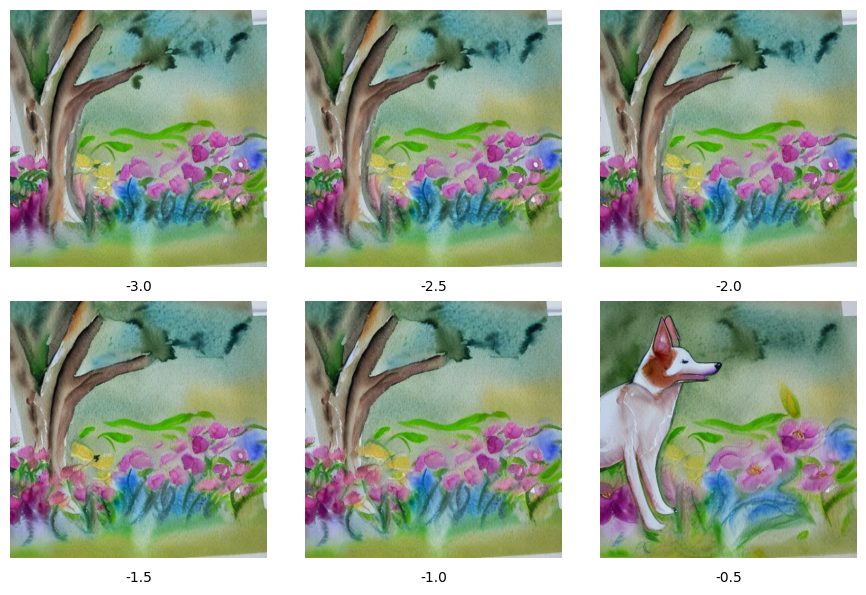

In [145]:
def steer_activations(x, r, lam=-1.0):
    if torch.all(r == 0).item():
        return x

    r = r.to(x.device, x.dtype)
    r /= r.norm()
        
    if x.ndim == 3:  # [C, H, W]
        r = r[:, None, None]      # shape [C, 1, 1]
        channel_dim = 0
    elif x.ndim == 4:  # [1, C, H, W]
        r = r[None, :, None, None] # shape [1, C, 1, 1]
        channel_dim = 1
    else: # [S, C] (ff layers)
        r = r[None, :] # shape [1, C]
        channel_dim = 1
        
    dot_product = (x * r).sum(dim=channel_dim, keepdim=True)
    
    return x + lam * dot_product * r


def steer_activations_pca(x, r, pca_data: tuple[torch.Tensor, torch.Tensor], lam: float = -1.0):
    #print(f'Steering on {x.shape} with {r.shape}')
    if torch.all(r == 0).item():
        return x

    r = r.to(x.device, x.dtype)

    pcs = pca_data[0].half().to(x.device)
    mean = pca_data[1].half().to(x.device)

    #print(f'{x.shape}, {mean.shape}')

    x -= mean

    x_compressed = x @ pcs
    r_compressed = r @ pcs
    r_constructed = r_compressed @ pcs.T
    
    r_compressed /= r_compressed.norm()
    r_constructed /= r_constructed.norm()
        
    if x.ndim == 3:  # [C, H, W]
        r = r[:, None, None]      # shape [C, 1, 1]
        channel_dim = 0
    elif x.ndim == 4:  # [1, C, H, W]
        r = r[None, :, None, None] # shape [1, C, 1, 1]
        channel_dim = 1
    else: # [S, C] (ff layers)
        r = r[None, :] # shape [1, C]
        channel_dim = 1
        
    dot_product = (x_compressed * r_compressed).sum(dim=channel_dim, keepdim=True)
    
    return x + lam * dot_product * r_constructed


def generate_with_steering(
    pipe: StableDiffusionPipeline,
    prompt: str,
    guidance: float,
    nets: dict,
    steering_vectors: dict[str, torch.Tensor],
    timesteps: list[int],
    inference_steps: int,
    lam: float,
    pca_dict: dict[str, dict[int, tuple[torch.Tensor, torch.Tensor]]]
):
    # designed to be simple, using batches would cause coherence issues when collecting acts.
    residuals_dict = {}
    handles = []

    current_step = 0

    def steering_hook(layer: str, steering_vector: torch.Tensor):
        ts_index = 0
        
        def hook(module, inp, out):
            nonlocal ts_index
            #print(f"[STEERING] layer={layer_name} step={current_step}")

            # out can be tensor or (hidden, tensor)
            if isinstance(out, tuple):
                hidden, residual = out
            else:
                hidden, residual = None, out  # residual: [B, C, H, W]
                
            if current_step in timesteps: 
                #print(f'[{layer}] -> Step {current_step}, ts_index {ts_index}')
                x = residual[1]

                pca_data = pca_dict.get(layer, {}).get(current_step, None) if pca_dict is not None else None

                if pca_data is not None:
                    x_steered = steer_activations_pca(x, steering_vector[ts_index], pca_data, lam)
                else:
                    x_steered = steer_activations(x, steering_vector[ts_index], lam)
                
                residual[1] = x_steered
                    
                ts_index += 1

            if hidden is None:
                return residual
            else:
                return (hidden, residual)

        return hook

    for layer, steering_vector in steering_vectors.items():
        handles.append(
            nets[layer].register_forward_hook(steering_hook(layer, steering_vector))
        )

    def callback(pipeline, step_index, timestep, callback_kwargs):
        nonlocal current_step
        current_step = step_index

        return callback_kwargs
    
    try:
        return pipe(
            prompt,
            num_inference_steps=inference_steps,
            guidance_scale=guidance,
            callback_on_step_end=callback,
            generator=torch.Generator(device="cuda").manual_seed(362)
        ).images
    except Exception as e:
        raise e
    finally:
        for h in handles:
            h.remove()


# Run generation with steering
prompt = dog_prompts[4]

all_images = []
lambdas = []
for lam in torch.arange(-3, 0, 0.5):
    steered_images = generate_with_steering(
        pipe,
        prompt,
        GUIDANCE,
        nets,
        filtered_vectors, # steering_vectors,
        timesteps=TIMESTEPS,
        inference_steps=STEPS,
        lam=lam,
        pca_dict=layer_principal_components
    )
    all_images.extend(steered_images)
    lambdas.append(str(lam.item()))

# Visualize
print(prompt)
show_images(all_images, lambdas, cols=3)